# Searching for Hardware Aware Neural Networks on ImageNet for FPGA in MobilenetV3 Search Space


We will be utilizing **[Once-for-All (OFA)](https://github.com/mit-han-lab/once-for-all)** network trained on MobilenetV3 search space as a our supernetwork to retrieve the weights and to estimate the accuracy of subnets in our search space because it requires significant amount of time to train each subnet for evaluating its perfomace. This slows down the searching process. Utilizing the OFA would speed up the search process as we won't have to train the network at all. The search is perfomed on the Imagenet Dataset. 


### 1. Preparation
Let's first install all the required packages:

In [9]:
# print('Installing PyTorch...')
# ! pip install torch 
# print('Installing torchvision...')
# ! pip install torchvision
# print('Installing numpy...')
# ! pip install numpy 
# # thop is a package for FLOPs computing.
# print('Installing thop (FLOPs counter) ...')
# ! pip install thop 
# # ofa is a package containing training code, pretrained specialized models and inference code for the once-for-all networks.
# # print('Installing OFA...')
# # ! pip install ofa 
# # tqdm is a package for displaying a progress bar.
# print('Installing tqdm (progress bar) ...')
# ! pip install tqdm 
# print('Installing matplotlib...')
# ! pip install matplotlib 
# print('All required packages have been successfully installed!')



In [10]:
# !pip install graphviz
# ! pip install torch-summary 


Then, we can import the packages used in this tutorial:

In [4]:
import os
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import numpy as np
import time
import random
import math
from PIL import Image
import copy
from matplotlib import pyplot as plt
from torchsummary import summary

from ofa.model_zoo import ofa_net
from ofa.utils import download_url

from ofa.accuracy_predictor import AccuracyPredictor
from ofa.flops_table import ArthIntTable

from ofa.latency_table import LatencyTable
from ofa.evolution_finder import EvolutionFinder
from ofa.imagenet_eval_helper import evaluate_ofa_subnet, evaluate_ofa_specialized

from ofa.utils.arch_visualization_helper import draw_arch
# from ofa.tutorial import AccuracyPredictor, FLOPsTable, LatencyTable, EvolutionFinder
# from ofa.tutorial import evaluate_ofa_subnet, evaluate_ofa_specialized

from ofa.imagenet_classification.elastic_nn.networks.ofa_mbv3 import OFAMobileNetV3
# set random seed
random_seed = 1
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
print('Successfully imported all packages and configured random seed to %d!'%random_seed)

Successfully imported all packages and configured random seed to 1!


In [5]:
# For kaggle
# !pip install graphviz
# ! pip install torch-summary 
# ! pip install gdown

# # ! git clone https://github.com/amitpant7/NAS-FPGA
# # ! mv /kaggle/working/NAS-FPGA/* /kaggle/working
# # ! rm -r NAS-FPGA

Now it's time to determine which device to use for neural network inference in the rest of this tutorial. If your machine is equipped with GPU(s), we will use the GPU by default. Otherwise, we will use the CPU.

In [6]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
cuda_available = torch.cuda.is_available()
if cuda_available:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    torch.cuda.manual_seed(random_seed)
    print('Using GPU.')
else:
    print('Using CPU.')

Using CPU.


###  2. Architecutre Visualization & Encoding: Exploring the OFA network 

Good! Now you have successfully configured the environment! It's time to import the **OFA network** for the following experiments.
The OFA network used in this tutorial is built upon MobileNetV3 with width multiplier 1.2, supporting elastic depth (2, 3, 4) per stage, elastic expand ratio (3, 4, 6), and elastic kernel size (3, 5 7) per block.

In [7]:
ofa_network = ofa_net('ofa_mbv3_d234_e346_k357_w1.2', pretrained=True)
print('The OFA Network is ready.')

The OFA Network is ready.


In [8]:
net_id  = 'ofa_mbv3_d234_e346_k357_w1.2'
url_base = "https://raw.githubusercontent.com/han-cai/files/master/ofa/ofa_nets/"

ofa_network = OFAMobileNetV3(
            dropout_rate=0,
            width_mult=1.2,
            ks_list=[3, 5, 7],
            expand_ratio_list=[3, 4, 6],
            depth_list=[2, 3, 4],
        )

pt_path = download_url(url_base + net_id, model_dir=".torch/ofa_nets")
init = torch.load(pt_path, map_location="cpu")["state_dict"]
ofa_network.load_state_dict(init)
print('Supernetwork Ready')

Supernetwork Ready


Lets visualize a randomly sampled network from our supernet.

In the architecture visualization, the legend of each block MBConv{e}-{k}x{k} means that the current block is a mobile inverted block with expand ratio e and the kernel size of the depthwise convolution layer is k. Different colors of the blocks indicate different kernel sizes, and gray blocks are network stage dividers. Different widths for the blocks indicate different expand ratios. We also annotate the output resolution close to each block.

In [12]:
# Randomly sample sub-networks from OFA network
cfg = ofa_network.sample_active_subnet()
subnet1 = ofa_network.get_active_subnet(preserve_weight=True)

image_size = 224

#manualy set the subnet 
cfg = ofa_network.set_active_subnet(ks=3, e=6, d=4)
subnet2 = ofa_network.get_active_subnet(preserve_weight=True)
cfg = ofa_network.set_max_net()

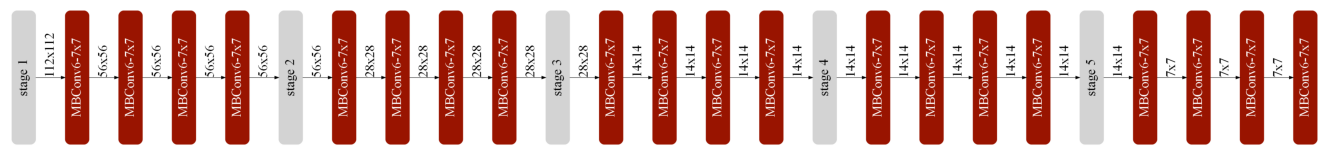

In [13]:
def visualize_subnet(cfg):
    draw_arch(cfg["ks"], cfg["e"], cfg["d"], image_size, out_name="viz/subnet")
    im = Image.open("viz/subnet.png")
    im = im.rotate(90, expand=1)
    fig = plt.figure(figsize=(im.size[0] / 250, im.size[1] / 250))
    plt.axis("off")
    plt.imshow(im)
    plt.show()

visualize_subnet(cfg)

In [13]:
cfg

{'ks': 7, 'e': 6, 'd': 4}

 
Every subnet in the ofa can be represented in the form of python dictionary. This encoding helps us to represent entire netowk with just few numbers.

Here is one expample of encoding

In [9]:
print('The architecture encoding of random subnetwork', cfg)

The architecture encoding of random subnetwork {'ks': [3, 7, 3, 5, 3, 5, 5, 5, 7, 5, 3, 3, 5, 3, 5, 5, 7, 3, 7, 5], 'e': [4, 6, 3, 6, 3, 4, 3, 3, 3, 6, 6, 3, 4, 6, 3, 4, 6, 3, 6, 3], 'd': [3, 3, 4, 2, 3]}


### 3. Dataset Preperation

Now, let's build the ImageNet dataset and the corresponding dataloader. Notice that **if you are not in kaggle it will be skipped** since it will be very slow.


We will only use subset of ImageNet validation set which will contains 10,000 images for testing.


In [10]:
if cuda_available:
    # path to the ImageNet dataset
    # link --> https://www.kaggle.com/datasets/titericz/imagenet1k-val
    
    imagenet_data_path = '/kaggle/input/imagenet1k-val/imagenet-val'

    # if 'imagenet_data_path' is empty, download a subset of ImageNet containing 2000 images (~250M) for test
    if not os.path.isdir(imagenet_data_path):
        print('%s is empty. Download a subset of ImageNet for test.' % imagenet_data_path)

    print('The ImageNet dataset files are ready.')
else:
    print('Since GPU is not found in the environment, we skip all scripts related to ImageNet evaluation.')

Since GPU is not found in the environment, we skip all scripts related to ImageNet evaluation.


Now you have configured the dataset. Let's build the dataloader for evaluation.
Again, this will be skipped if you are in a CPU environment.

In [11]:
if cuda_available:
    # The following function build the data transforms for test
    def build_val_transform(size):
        return transforms.Compose([
            transforms.Resize(int(math.ceil(size / 0.875))),
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
        ])

    data_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(
            root=os.path.join(imagenet_data_path, 'images'),
            transform=build_val_transform(224)
        ),
        batch_size=250,  # test batch size
        shuffle=True,
        num_workers=16,  # number of workers for the data loader
        pin_memory=True,
        drop_last=False,
    )
    print('The ImageNet dataloader is ready.')
else:
    data_loader = None
    print('Since GPU is not found in the environment, we skip all scripts related to ImageNet evaluation.')

Since GPU is not found in the environment, we skip all scripts related to ImageNet evaluation.


### 4. Accuracy Predictor 

The key components of very fast neural network deployment are **accuracy predictors** and **efficiency predictors**.
For the accuracy predictor, it predicts the Top-1 accuracy of a given sub-network on a **holdout validation set**
(different from the official 50K validation set) so that we do **NOT** need to run very costly inference on ImageNet
while searching for specialized models. Such an accuracy predictor is trained using an accuracy dataset built with the OFA network.

![](../figures/predictor_based_search.png)

In [12]:
# accuracy predictor
accuracy_predictor = AccuracyPredictor(
    pretrained=True,
    device='cuda:0' if cuda_available else 'cpu'
)

print('The accuracy predictor is ready!')
print(accuracy_predictor.model)

The accuracy predictor is ready!
Sequential(
  (0): Linear(in_features=128, out_features=400, bias=True)
  (1): ReLU()
  (2): Linear(in_features=400, out_features=400, bias=True)
  (3): ReLU()
  (4): Linear(in_features=400, out_features=400, bias=True)
  (5): ReLU()
  (6): Linear(in_features=400, out_features=1, bias=True)
)


Now, we have the powerful **accuracy predictor**. We then introduce two types of **efficiency predictors**: the latency predictor and the FLOPs predictor. 

The intuition of having efficiency predictors, especially the latency predictor, is that measuring the latency of a sub-network on-the-fly is also costly, especially for FPGA devices becuase it takes hours of work to implement even a single network and then measure latency.

The latency predictor is designed to eliminate this cost.

### 5. Searching with Arthemetic Intensity Constraint
For edge deployement like FPGAs computation is cheap where as memory movement is expensive. That's why we need to do as much as computation with fewer number of data movement. This can be defined by arthemetic constraint which is the ratio of MACs to size in bytes. 

Now, let's proceed towards searching for efficient network under arthemetic intensity constraint. We use the same accuracy predictor since accuracy predictors are agnostic to the types of efficiency constraint . For the efficiency predictor, we a arthametic intensity table. You can run the code below to setup it in a few seconds.

In [13]:
arthemetic_intensity_lookup = ArthIntTable(pred_type='arthemetic_intensity', 
                                  device='cuda:0' if cuda_available else 'cpu',batch_size=1, 
                                  )

print('The Arthemetic Intensity lookup table is ready!')

Building the arthemetic_intensity lookup table (resolution=224)...
Built the arthemetic_intensity lookup table (resolution=224)!
The Arthemetic Intensity lookup table is ready!


Lets try to find the Arthemetic intensity of our random sampled subnet

In [15]:
arth = 1/arthemetic_intensity_lookup.predict_efficiency(cfg)   #as it returns bytes/ops
print('arthemetic intensity = {} ops/byte'.format(arth))

arthemetic intensity = 13.949004287404314 ops/byte


#### Run Evolutionary search

In [16]:
#  Hyper-parameters for the evolutionary search process

P = 10000  # The size of population in each generation
N = 500  # How many generations of population to be searched
r = 0.25  # The ratio of networks that are used as parents for next generation

params = {
    'constraint_type': 'arthemetic_intensity', # Let's do FLOPs-constrained search
    'efficiency_constraint': 13,  # FLops constraint (M), suggested range [150, 600]
    'mutate_prob': 0.1, # The probability of mutation in evolutionary search
    'mutation_ratio': 0.5, # The ratio of networks that are generated through mutation in generation n >= 2.
    'efficiency_predictor': arthemetic_intensity_lookup, # To use a predefined efficiency predictor.
    'accuracy_predictor': accuracy_predictor, # To use a predefined accuracy_predictor predictor.
    'population_size': P,
    'max_time_budget': N,
    'parent_ratio': r,
}

# build the evolution finder
finder = EvolutionFinder(**params)

# start searching
result_lis = []
for arth_intensity in [12, 14, 15]:
    st = time.time()
    finder.set_efficiency_constraint(arth_intensity)
    best_valids, best_info = finder.run_evolution_search()
    ed = time.time()
    print('Found best architecture at arthemetic intensity >= %.2f M in %.2f seconds! It achieves %.2f%s predicted accuracy with arthemetic intensity of %.2f ops/byte./n' % (arth_intensity, ed-st, best_info[0] * 100, '%',1/ best_info[-1]))
    result_lis.append(best_info)



Generate random population...
Start Evolution...


Searching with arthemetic_intensity constraint (0.08333333333333333):  13%|█▎        | 64/500 [00:10<01:09,  6.28it/s]


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(4,4))
plt.plot([x[-1] for x in result_lis], [x[0] * 100 for x in result_lis], 'x-', marker='*', color='darkred',  linewidth=2, markersize=8, label='OFA')
plt.xlabel('Arthemetic Intensity (ops/byte)', size=12)
plt.ylabel('Predicted Holdout Top-1 Accuracy (%)', size=12)
plt.legend(['OFA'], loc='lower right')
plt.grid(True)
plt.show()

In [19]:
import torch.onnx 

#Function to Convert to ONNX 
def Convert_ONNX(model, in_shape, name): 

    # set the model to inference mode 
    model.eval() 

    # Let's create a dummy input tensor  

    dummy_input = torch.randn(in_shape, requires_grad=True)  

    # Export the model   
    torch.onnx.export(model,         # model being run 
         dummy_input,       # model input (or a tuple for multiple inputs) 
         f"{name}.onnx",       # where to save the model  
         export_params=True,  # store the trained parameter weights inside the model file 
         opset_version=10,    # the ONNX version to export the model to 
         do_constant_folding=True,  # whether to execute constant folding for optimization 
         input_names = ['modelInput'],   # the model's input names 
         output_names = ['modelOutput'], # the model's output names 
         dynamic_axes={'modelInput' : {0 : 'batch_size'},    # variable length axes 
                                'modelOutput' : {0 : 'batch_size'}}) 
    print(" ") 
    print('Model has been converted to ONNX')